In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data.loader import load_prices, compute_returns
from src.models.lr import predict_mean_returns
from outputs.charts.markowitz_plot import compare_pure_mk_with_lr, plot_compare_time_series


In [2]:
tickers = [
    "PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "GGBR4.SA"
]

start_date = "2017-01-01"
end_date = "2023-01-01"

prices = load_prices(tickers, start=start_date, end=end_date)


/workspaces/deep_learning_finance/src/data/loader.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  9 of 9 completed


In [3]:
returns_daily = compute_returns(prices, freq="daily")
pure_daily = returns_daily.mean()
cov_daily = returns_daily.cov()

pred_daily = predict_mean_returns(prices, window=5)

returns_monthly = compute_returns(prices, freq="monthly")
pure_monthly = returns_monthly.mean()
cov_monthly = returns_monthly.cov()




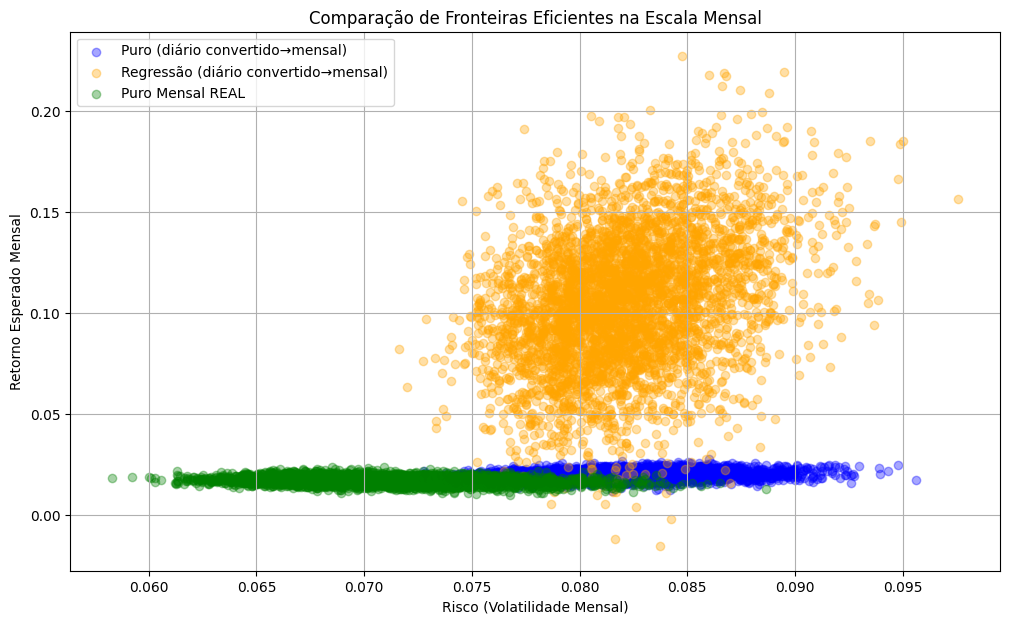

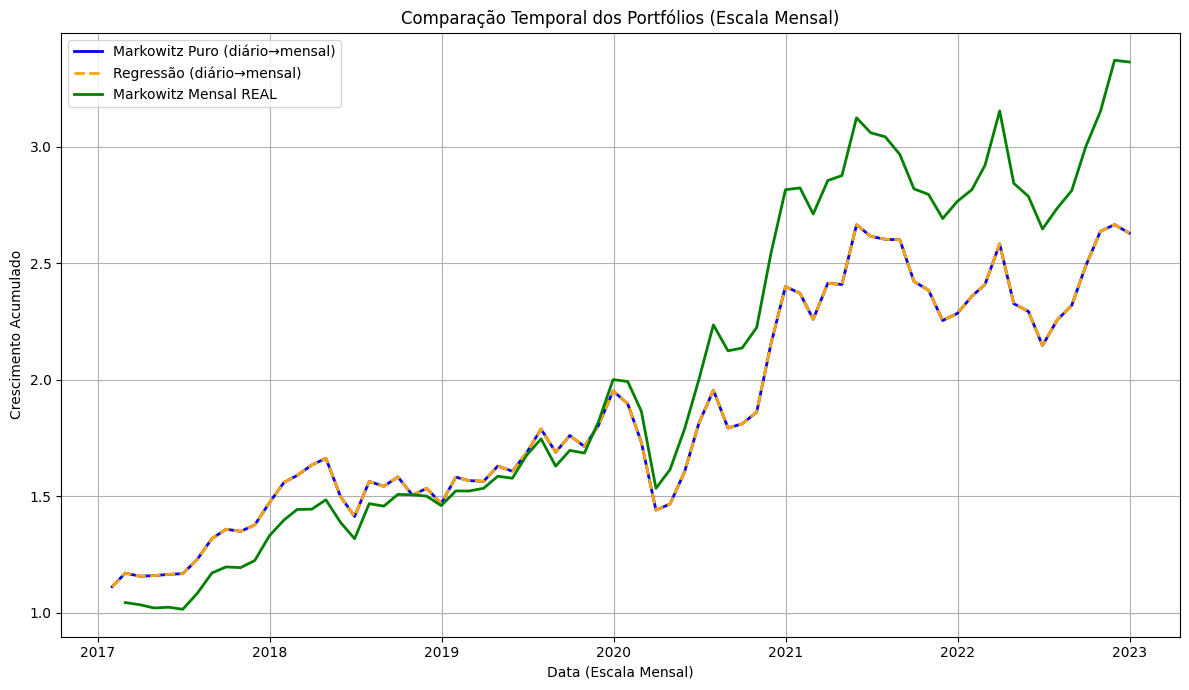

In [4]:
compare_pure_mk_with_lr(
    pure_daily_returns=pure_daily,
    predicted_daily_returns=pred_daily,
    cov_daily=cov_daily,
    pure_monthly_returns=pure_monthly,
    cov_monthly=cov_monthly
)

plot_compare_time_series(
    returns_daily,
    returns_monthly,
    pure_daily,
    pred_daily,
    pure_monthly,
    cov_daily,
    cov_monthly
)

,Model,Mean,Volatility,Sharpe,Cumulative_Return
0,standard_markowitz,0.000763,0.015083,0.802919,1.629303
0,linear_metrics,0.000763,0.015083,0.802917,1.629297


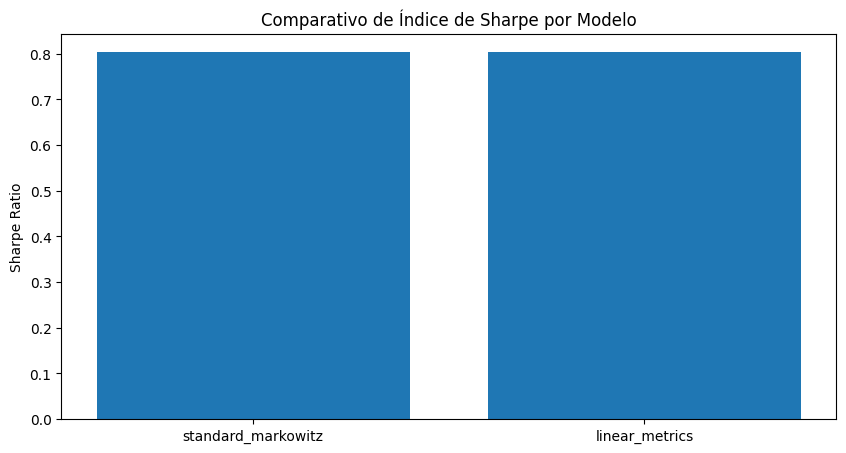

In [5]:


files = [
    "../outputs/models/standard_markowitz.csv",
    "../outputs/models/linear_metrics.csv",
    #"../outputs/models/xgboost_metrics.csv",
    #"../outputs/models/mlp_metrics.csv",
    #"../outputs/models/lstm_metrics.csv"
]

df_results = pd.concat([pd.read_csv(f) for f in files])

# Comparar desempenho
display(df_results)

# Plotar comparativo de Sharpe
plt.figure(figsize=(10, 5))
plt.bar(df_results['Model'], df_results['Sharpe'])
plt.title("Comparativo de Índice de Sharpe por Modelo")
plt.ylabel("Sharpe Ratio")
plt.show()
